In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import torch.cuda
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [3]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "white"}

# Load/Preprocess data

Motility should be translationally and rotationally invariant, so we have all tracks start at (0,0) and rotate them all to a standard orientation.

In [4]:
def load_data(filename):
    with open(filename) as f:
        data = json.load(f)

    # Make all tracks start at 0,0
    for v in data.values():
        pos = np.array(v["txy"])
        pos -= pos[0]
        v["txy"] = pos

    # Rotate all tracks to the same orientation
    for v in data.values():
        pos = np.array(v["txy"])
        angle = -np.arctan2(pos[-1,1], pos[-1,2])
        rot = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        pos[:,1:] = pos[:,1:] @ rot
        v["txy"] = pos

    return data

In [5]:
train_data = load_data("train.json")
test_data = load_data("test.json")

In [6]:
lab_data = {k:v for k,v in train_data.items() if "lab" in k}
sim_data = {k:v for k,v in train_data.items() if "sim" in k}

print(f"lab samples: {len(lab_data)}, sim samples: {len(sim_data)}")

lab samples: 368, sim samples: 15712


## Plot some tracks

In [123]:
sim_motile_uids = [x for x in train_data.keys() if train_data[x]['label'] == 1 and 'sim' in x]
sim_nonmotile_uids = [x for x in train_data.keys() if train_data[x]['label'] == 0 and 'sim' in x]
lab_motile_uids = [x for x in train_data.keys() if train_data[x]['label'] == 1 and 'lab' in x]
lab_nonmotile_uids = [x for x in train_data.keys() if train_data[x]['label'] == 0 and 'lab' in x]

In [282]:
def plot_tracks(tracklist, title):
    # plot given tracks
    fig, ax = plt.subplots(figsize=(5,5))
    for t in tracklist:
        ax.plot(t[:,1], t[:,2])
    
    ax.set_xlim([-500, 500])
    ax.set_ylim([-100, 1000])
    ax.set_aspect(1.0)
    ax.set_title(title)

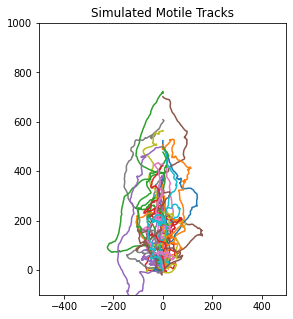

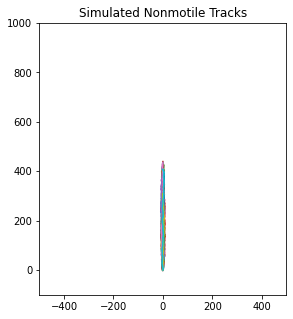

In [283]:
# Plot 10 simulated motile tracks
plot_uids = random.choices(sim_motile_uids, k=50)
to_plot = [np.array(train_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Simulated Motile Tracks')

# Plot 10 simulated nonmotile tracks
plot_uids = random.choices(sim_nonmotile_uids, k=50)
to_plot = [np.array(train_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Simulated Nonmotile Tracks')

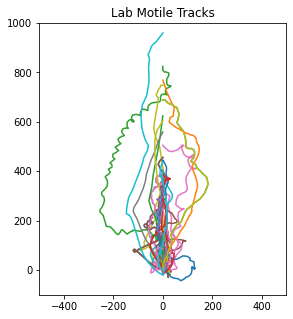

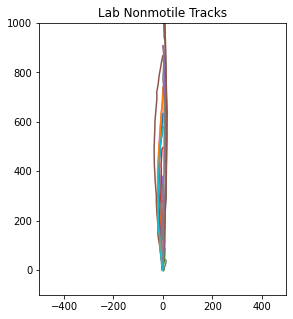

In [284]:
# Plot 10 lab motile tracks
plot_uids = random.choices(lab_motile_uids, k=50)
to_plot = [np.array(train_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Lab Motile Tracks')

# Plot 10 lab nonmotile tracks
plot_uids = random.choices(lab_nonmotile_uids, k=50)
to_plot = [np.array(train_data[u]['txy']) for u in plot_uids]

plot_tracks(to_plot, 'Lab Nonmotile Tracks')

# PyTorch

### Set up torch datasets

First, define functions for converting the data from dicts to numpy arrays.

Tracks have variable lengths, so we pad short ones with zeros and truncate long ones.
We add an additional channel to mark which data is padding, so the model can (in theory) learn to ignore it.

For augmentation, we duplicate the data and mirror it. We also tried randomly stretching/squishing it, but didn't see any improvement in performance.

In [20]:
def data_to_numpy(data, shuffle=False, max_len=None):
    if max_len is None:
        max_len = max(len(v["txy"]) for v in data.values())

    X = np.zeros((len(data), max_len, 3))
    Y = np.zeros((len(data), 1))

    for i, v in enumerate(data.values()):
        track_len = len(v["txy"])
        X[i,:len(v["txy"]),:-1] = v["txy"][:min(track_len, max_len),1:]

        # pad with zeros
        if (track_len < max_len):
            X[i,len(v["txy"]):,:-1] = 0
            X[i,len(v["txy"]):,-1] = 1

        Y[i] = v["label"]

    # Pytorch wants (batch, channel, length)
    X = X.transpose(0,2,1)

    # Shuffle data
    if (shuffle):
        idx = np.arange(len(X))
        np.random.shuffle(idx)
        X = X[idx]
        Y = Y[idx]

    return X, Y

def augment(X, Y):
    data_len = len(X)

    X = np.repeat(X, 2, axis=0)
    Y = np.repeat(Y, 2, axis=0)

    X[data_len:,0,:] *= -1
    # X[data_len:,0,:] *= 0.9 + np.random.random(data_len)[:,None] * 0.2 # randomly scale x
    # X[data_len:,1,:] *= 0.9 + np.random.random(data_len)[:,None] * 0.2 # randomly scale y

    # shuffle
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]

    return X, Y

To avoid contami

In [8]:
# Create training and test datasets in pytorch
def create_datasets(train_data, max_len=350, val_cutoff=0.8):
    X, Y = data_to_numpy(train_data, shuffle=True, max_len=max_len)

    cutoff = int(len(X) * val_cutoff)
    train_X, train_Y = augment(X[:cutoff], Y[:cutoff])
    val_X, val_Y = X[cutoff:], Y[cutoff:]

    torch_train_X = torch.from_numpy(train_X).float()
    torch_train_Y = torch.from_numpy(train_Y).float()
    torch_val_X = torch.from_numpy(val_X).float()
    torch_val_Y = torch.from_numpy(val_Y).float()

    train_dataset = torch.utils.data.TensorDataset(torch_train_X, torch_train_Y)
    val_dataset = torch.utils.data.TensorDataset(torch_val_X, torch_val_Y)

    return train_dataset, val_dataset

## Create model

The overall architecture is: conv(5x5x10) -> conv(5x5x30) -> maxpool(2) -> conv(5x5x30) -> conv(5x5x60) -> maxpool(2) -> dense(256) -> dense(128) -> output

This was chosen with experimentation by hand (for selecting the number of layers and sizes).

We then modified the model to have additional small hidden layer at the end to try to extract useful features for the boosted decision tree model. It didn't seem to affect performance much.

In [54]:
def create_model(dropout, learning_rate=2e-5, pos_weight=1, track_len=350):
    model = nn.Sequential(
        nn.Conv1d(3, 10, 5, padding=2),
        nn.BatchNorm1d(10),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Conv1d(10, 30, 5, padding=2),
        nn.BatchNorm1d(30),
        nn.ReLU(),
        nn.MaxPool1d(2),
        nn.Dropout(dropout),

        nn.Conv1d(30, 30, 5, padding=2),
        nn.BatchNorm1d(30),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Conv1d(30, 60, 5, padding=2),
        nn.BatchNorm1d(60),
        nn.ReLU(),
        nn.MaxPool1d(2),
        nn.Dropout(dropout),

        nn.Flatten(),
        nn.Linear(60 * (track_len // 4), 256),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(128, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
    ).cuda()

    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight)).cuda()
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    return model, loss_fn, optimizer

## Functions for training/testing

In [1]:
def train(model, loss_fn, optimizer, train_dataset, val_dataset, n_epochs, batch_size=32, l1reg=1e-4, print_losses=False):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model.train()

    train_losses = []
    test_losses = []

    loss_eval_interval = 15000 // batch_size

    for epoch in tqdm(range(n_epochs)):
        running_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            pred = model(data)
            loss = loss_fn(pred, target)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % loss_eval_interval == loss_eval_interval - 1:
                train_losses.append(running_loss / (loss_eval_interval))
                running_loss = 0

                test_loss = 0
                with torch.no_grad():
                    for data, target in val_loader:
                        data, target = data.cuda(), target.cuda()
                        pred = model(data)
                        loss = loss_fn(pred, target)
                        test_loss += loss.item()

                test_losses.append(test_loss / (len(val_loader)))

        if print_losses:
            print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses

In [12]:
# Test model, print accuracy and f2 score
def test(model, loss_fn, dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

    model.eval()

    test_loss = 0
    correct = 0

    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.cuda(), target.cuda()

            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output > 0
            correct += pred.eq(target.view_as(pred)).sum().item()

            true_pos += ((pred == 1) & (target == 1)).sum().item()
            false_pos += ((pred == 1) & (target == 0)).sum().item()
            true_neg += ((pred == 0) & (target == 0)).sum().item()
            false_neg += ((pred == 0) & (target == 1)).sum().item()

    test_loss /= len(loader)

    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f2 = (5 * precision * recall) / (4 * precision + recall)

    print(f"Test loss: {test_loss:.4f}")
    print(f"Accuracy: {correct / len(loader.dataset):.4f} ({correct}/{len(loader.dataset)})")
    print(f"F2 score: {f2:.4f}")

## Test different dropouts

In [19]:
train_losses = []
test_losses = []

train_dataset, val_dataset = create_datasets(train_data)

for i,d in enumerate(np.linspace(0, 0.2, 5)):
    torch.manual_seed(0)
    model, loss_fn, optimizer = create_model(d, pos_weight=2)
    train_loss, test_loss = train(model, loss_fn, optimizer, train_dataset, val_dataset, 50, batch_size=128)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Dropout: {d:.2f}")
    test(model, loss_fn, val_dataset)
    print()

  0%|          | 0/50 [00:00<?, ?it/s]

Dropout: 0.00
Test loss: 0.0795
Accuracy: 0.9876 (3176/3216)
F2 score: 0.9920



  0%|          | 0/50 [00:00<?, ?it/s]

Dropout: 0.05
Test loss: 0.0586
Accuracy: 0.9854 (3169/3216)
F2 score: 0.9899



  0%|          | 0/50 [00:00<?, ?it/s]

Dropout: 0.10
Test loss: 0.0821
Accuracy: 0.9810 (3155/3216)
F2 score: 0.9841



  0%|          | 0/50 [00:00<?, ?it/s]

Dropout: 0.15
Test loss: 0.1252
Accuracy: 0.9742 (3133/3216)
F2 score: 0.9721



  0%|          | 0/50 [00:00<?, ?it/s]

Dropout: 0.20
Test loss: 0.2245
Accuracy: 0.9518 (3061/3216)
F2 score: 0.9214



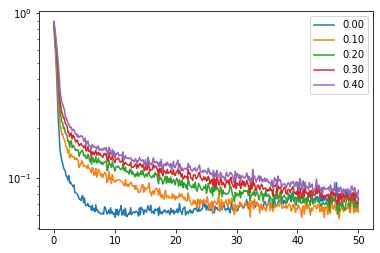

In [20]:
epoch_steps = np.linspace(0, 50, len(train_losses[0]))

for i, curve in enumerate(test_losses):
    plt.plot(epoch_steps, curve, label=f"{i*0.1:.2f}")
plt.yscale("log")
plt.legend()

We get the best performance with dropout 0.05

## Test the best model

In [15]:
train_dataset, val_dataset = create_datasets(train_data)

print(train_dataset.tensors[0].shape, val_dataset.tensors[0].shape)

torch.Size([25728, 3, 350]) torch.Size([3216, 3, 350])


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.5459, Test Loss: 0.3666
Epoch 2, Train Loss: 0.2241, Test Loss: 0.2158
Epoch 3, Train Loss: 0.1683, Test Loss: 0.1732
Epoch 4, Train Loss: 0.1410, Test Loss: 0.1612
Epoch 5, Train Loss: 0.1395, Test Loss: 0.1507
Epoch 6, Train Loss: 0.1283, Test Loss: 0.1350
Epoch 7, Train Loss: 0.1173, Test Loss: 0.1367
Epoch 8, Train Loss: 0.1143, Test Loss: 0.1271
Epoch 9, Train Loss: 0.1106, Test Loss: 0.1280
Epoch 10, Train Loss: 0.0999, Test Loss: 0.1193
Epoch 11, Train Loss: 0.1070, Test Loss: 0.1150
Epoch 12, Train Loss: 0.1025, Test Loss: 0.1138
Epoch 13, Train Loss: 0.0943, Test Loss: 0.1103
Epoch 14, Train Loss: 0.0938, Test Loss: 0.1093
Epoch 15, Train Loss: 0.0909, Test Loss: 0.1056
Epoch 16, Train Loss: 0.0940, Test Loss: 0.1031
Epoch 17, Train Loss: 0.0906, Test Loss: 0.1055
Epoch 18, Train Loss: 0.0902, Test Loss: 0.1009
Epoch 19, Train Loss: 0.0820, Test Loss: 0.1009
Epoch 20, Train Loss: 0.0832, Test Loss: 0.1005
Epoch 21, Train Loss: 0.0803, Test Loss: 0.1012
E

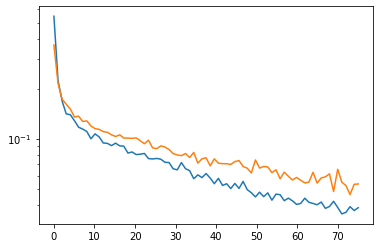

In [67]:
n_epochs = 75

torch.manual_seed(0)
model, loss_fn, optimizer = create_model(0.05, learning_rate=1.2e-5, pos_weight=2)
train_loss, test_loss = train(model, loss_fn, optimizer, train_dataset, val_dataset, n_epochs, batch_size=128, l1reg=0.1, print_losses=True)

epoch_steps = np.linspace(0, n_epochs, len(train_loss))
plt.plot(epoch_steps, train_loss)
plt.plot(epoch_steps, test_loss)
plt.yscale("log")

test(model, loss_fn, val_dataset)
print()

In [69]:
test(model, loss_fn, val_dataset)

Test loss: 0.0410
Accuracy: 0.9876 (3176/3216)
F2 score: 0.9935


In [70]:
# Create a test dataset of only lab data
lab_X, lab_Y = data_to_numpy(lab_data, max_len=350)
lab_dataset = torch.utils.data.TensorDataset(torch.tensor(lab_X).float(), torch.tensor(lab_Y).float())

test(model, loss_fn, lab_dataset)

Test loss: 0.2928
Accuracy: 0.9375 (345/368)
F2 score: 0.9176


## Train an ensemble of models

Train several models, and remake the training/validation sets each time so they each get trained on a different subset of the training data.

  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.0418
Accuracy: 0.9919 (3190/3216)
F2 score: 0.9940



  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.0506
Accuracy: 0.9888 (3180/3216)
F2 score: 0.9889



  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.0454
Accuracy: 0.9900 (3184/3216)
F2 score: 0.9915



  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.0870
Accuracy: 0.9835 (3163/3216)
F2 score: 0.9823



  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.0865
Accuracy: 0.9820 (3158/3216)
F2 score: 0.9803



  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.0443
Accuracy: 0.9885 (3179/3216)
F2 score: 0.9898



  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.1052
Accuracy: 0.9807 (3154/3216)
F2 score: 0.9784



  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.0995
Accuracy: 0.9817 (3157/3216)
F2 score: 0.9754



  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.0819
Accuracy: 0.9773 (3143/3216)
F2 score: 0.9660



  0%|          | 0/75 [00:00<?, ?it/s]

Test loss: 0.0661
Accuracy: 0.9866 (3173/3216)
F2 score: 0.9866



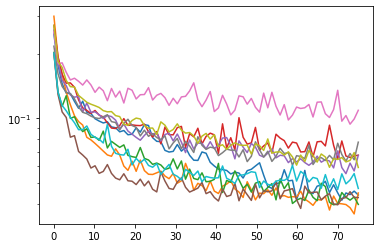

In [108]:
torch.manual_seed(0)

n_models = 10
models = []

for i in range(n_models):
    train_dataset, val_dataset = create_datasets(train_data)
    model, loss_fn, optimizer = create_model(0.1, pos_weight=2)
    train_losses, test_losses = train(model, loss_fn, optimizer, train_dataset, val_dataset, 75, batch_size=128, print_losses=False)
    test(model, loss_fn, val_dataset)
    print()

    epoch_steps = np.linspace(0, 75, len(train_losses))
    # plt.plot(epoch_steps, train_losses, label=f"Train {i}")
    plt.plot(epoch_steps, test_losses)

    models.append(model)

plt.yscale("log")

## Generate submission data

In [265]:
X, _ = data_to_numpy(test_data, shuffle=False, max_len=350)
torch_X = torch.from_numpy(X).float().cuda()
output = torch.zeros((len(X), 1)).cuda()

for model in models:
    model.eval()
    with torch.no_grad():
        output += model(torch_X)

In [266]:
import csv

# Create submission file
with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    writer.writerow(["UID", "label"])

    for i, k in enumerate(test_data.keys()):
        pred = int(output[i].item() > 0)
        writer.writerow([k, pred])

## Generate outputs for use as a feature in Boosted Decision Trees

In [316]:
feature_extractor = nn.Sequential(*list(model.children())[:-2])
feature_extractor.eval()

Sequential(
  (0): Conv1d(3, 10, kernel_size=(5,), stride=(1,), padding=(2,))
  (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.05, inplace=False)
  (4): Conv1d(10, 30, kernel_size=(5,), stride=(1,), padding=(2,))
  (5): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Dropout(p=0.05, inplace=False)
  (9): Conv1d(30, 30, kernel_size=(5,), stride=(1,), padding=(2,))
  (10): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.05, inplace=False)
  (13): Conv1d(30, 60, kernel_size=(5,), stride=(1,), padding=(2,))
  (14): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()
  (16): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Dropout(p=0.05, inplace=

### Training data (last layer features)

In [317]:
X, _ = data_to_numpy(train_data, shuffle=False, max_len=350)
torch_X = torch.from_numpy(X).float().cuda()

dataset = torch.utils.data.TensorDataset(torch_X)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

keys = list(train_data.keys())

with open('train_outputs.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    for i, (x,) in enumerate(loader):
        with torch.no_grad():
            output = feature_extractor(x)
            
            for j in range(output.shape[0]):
                writer.writerow([keys[i*128 + j], *output[j, :].cpu().numpy()])

### Scoring data (last layer features)

In [318]:
X, _ = data_to_numpy(test_data, shuffle=False, max_len=350)
torch_X = torch.from_numpy(X).float().cuda()

with torch.no_grad():
    output = feature_extractor(torch_X)

with open('test_outputs.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    for i, k in enumerate(test_data.keys()):
        writer.writerow([k, *output[i].cpu().numpy()])

### Training data (ensemble)

In [264]:
X, _ = data_to_numpy(train_data, shuffle=False, max_len=350)
torch_X = torch.from_numpy(X).float().cuda()

dataset = torch.utils.data.TensorDataset(torch_X)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

output = torch.zeros((len(X), 1)).cuda()

for model in models:
    model.eval()
    
    for i, (x,) in enumerate(loader):
        with torch.no_grad():
            output[i*128:(i+1)*128] += model(x)

with open('train_outputs.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    for i, k in enumerate(train_data.keys()):
        writer.writerow([k, output[i].item()])

### Scoring data (ensemble)

In [267]:
X, _ = data_to_numpy(test_data, shuffle=False, max_len=350)
torch_X = torch.from_numpy(X).float().cuda()

output = torch.zeros((len(X), 1)).cuda()

for model in models:
    model.eval()
    with torch.no_grad():
        output += model(torch_X)

with open('test_outputs.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    for i, k in enumerate(test_data.keys()):
        writer.writerow([k, output[i].item()])

## Visualize Model Performance

In [286]:
# import train_outputs.csv
import pandas as pd
train_outputs = pd.read_csv("train_outputs.csv", header=None)
train_outputs.head()

,0,1,2,3,4,5,6,7,8
0,lab_0_0,-5.848777,-2.550826,-4.744375,13.618042,-2.410615,-2.411192,-2.594977,-4.509803
1,lab_0_1,-5.139762,-2.260276,-4.164068,12.212698,-2.169159,-2.131933,-2.332766,-3.975975
2,lab_0_2,-6.644589,-2.864593,-5.407369,15.225113,-2.620270,-2.713874,-2.860753,-5.090699
3,lab_0_3,-5.712951,-2.458815,-4.608340,13.471096,-2.508360,-2.304050,-2.596767,-4.377955
4,lab_0_4,-2.933701,-1.343834,-2.323585,10.063562,-2.319760,-1.409253,-2.107604,-2.234412


In [320]:
train_outputs.shape

(16080, 9)

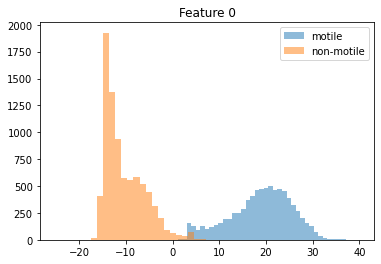

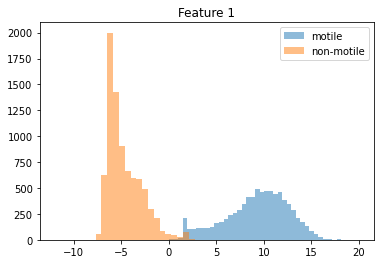

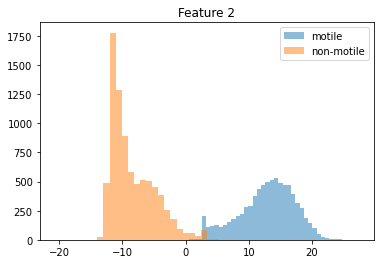

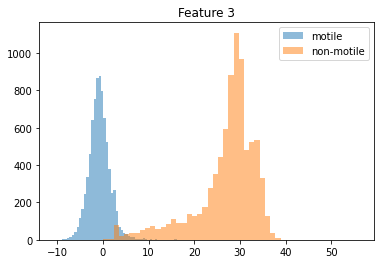

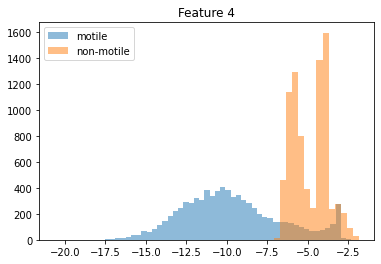

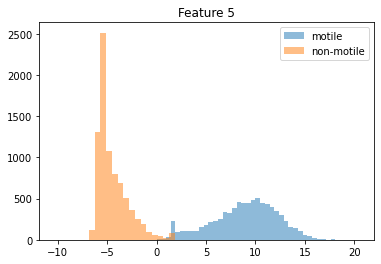

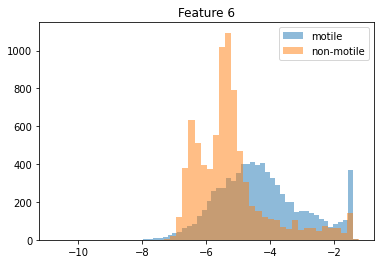

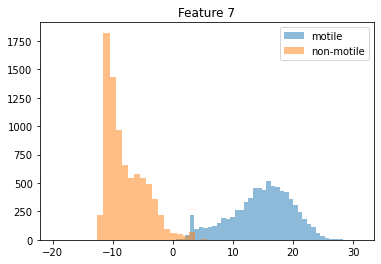

In [342]:
# plot a histogram of the outputs from the csv for motile and non-motile
motile = []
non_motile = []

for i in range(train_outputs.shape[0]):
    key = train_outputs.iloc[i, 0]
    if train_data[key]["label"] == 1:
        motile.append(train_outputs.iloc[i, 1:])
    else:
        non_motile.append(train_outputs.iloc[i, 1:])

motile = np.array(motile)
non_motile = np.array(non_motile)

for i in range(train_outputs.shape[1] - 1):
    plt.hist(motile[:, i], bins=50, alpha=0.5, label="motile")
    plt.hist(non_motile[:, i], bins=50, alpha=0.5, label="non-motile")
    plt.legend()
    plt.title("Feature " + str(i))
    plt.show()

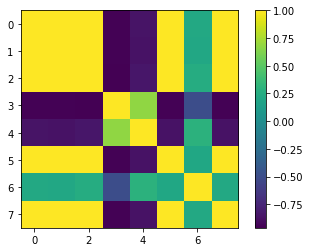

In [354]:
# Find correlation between features
all_features = np.concatenate((motile, non_motile)).astype(np.float32)
corr = np.corrcoef(all_features, rowvar=False)
plt.imshow(corr)
plt.colorbar()

In [50]:
# plot a histogram of model output for each class
motile = []
non_motile = []

loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

for batch_idx, (x, y) in enumerate(loader):
    x, y = x.cuda(), y.cuda()
    with torch.no_grad():
        output = model(x)
        for i in range(len(y)):
            if y[i] == 1:
                motile.append(output[i].item())
            else:
                non_motile.append(output[i].item())

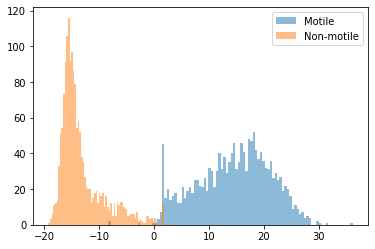

In [51]:
# plot histograms
plt.hist(motile, bins=100, alpha=0.5, label="Motile")
plt.hist(non_motile, bins=100, alpha=0.5, label="Non-motile")
plt.legend()
plt.savefig("histogram.png")